In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk

In [39]:
dataPath = './Data/'
X_stop_digits_lemma = np.load(dataPath + 'X.npy', allow_pickle=True)
X_stop_lemma    = np.load(dataPath + 'X_stop_lemma.npy', allow_pickle=True)
X_stop_stem     = np.load(dataPath + 'X_stop_stem.npy', allow_pickle=True)
X_stop          = np.load(dataPath + 'X_stop.npy', allow_pickle=True)
X               = np.load(dataPath + 'X.npy', allow_pickle=True)
y = np.load(dataPath + 'y.npy', allow_pickle=True)

X_TEST_STOP_LEMMA = np.load(dataPath + 'X_TEST_STOP_LEMMA.npy', allow_pickle=True)

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_stop_lemma, y, test_size=0.2, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(strip_accents='unicode', sublinear_tf=True, min_df=3 ,max_features=104000)
X_train = vectorizer.fit_transform(X_train)
X_valid = vectorizer.transform(X_valid)

In [42]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, C=2).fit(X_train, y_train)

from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_valid)
print(accuracy_score(y_valid, y_pred))


0.7235987490979071


In [46]:

from sklearn.metrics import accuracy_score, f1_score

print(f'Accuracy of Logistic Regression: {accuracy_score(y_valid, y_pred)}')
print(f'F1 Score of Logistic Regression: {f1_score(y_valid, y_pred, average="macro")}')


Accuracy of Logistic Regression with C=2: 0.7235987490979071
F1 Score of Logistic Regression with C=2: 0.6618778942834758


In [11]:
# k fold cross validation
# remove the warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, random_state=42, shuffle=True)
accuracies = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = kfold)

print(f'Accuracy: {accuracies.mean()*100:.2f} %')
print(f'Standard Deviation: {accuracies.std()*100:.2f} %')
print(f'Accuracies: {accuracies}')


Accuracy: 73.02 %
Standard Deviation: 0.61 %
Accuracies: [0.7191822  0.72996542 0.73041648 0.73447602 0.73703203]


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
accuracies = cross_val_score(estimator = clf, X = X_train, y = y_train, cv = cv)

print(f'Accuracy: {accuracies.mean()*100:.2f} %')
print(f'Standard Deviation: {accuracies .std()*100:.2f} %')
print(f'Accuracies: {accuracies}')


Accuracy: 72.83 %
Standard Deviation: 0.48 %
Accuracies: [0.71903187 0.72820204 0.73120866 0.73120866 0.73165965]


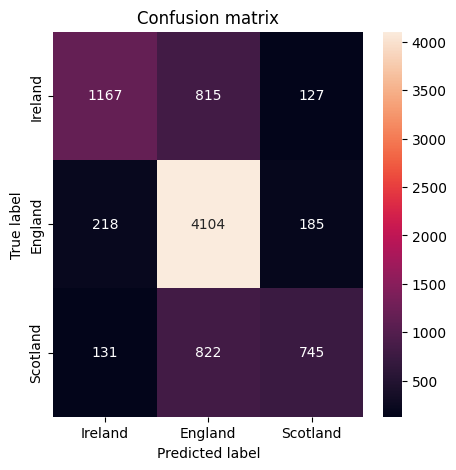

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

label2id = {
    'Ireland': 0,
    'England': 1,
    'Scotland': 2,
}

cm = confusion_matrix(y_valid, y_pred)
df_cm = pd.DataFrame(cm, index = [i for i in label2id.keys()],
columns = [i for i in label2id.keys()])


plt.figure(figsize=(5,5))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [16]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, y_pred,  target_names=label2id.keys()))

              precision    recall  f1-score   support

     Ireland       0.77      0.55      0.64      2109
     England       0.71      0.91      0.80      4507
    Scotland       0.70      0.44      0.54      1698

    accuracy                           0.72      8314
   macro avg       0.73      0.63      0.66      8314
weighted avg       0.73      0.72      0.71      8314



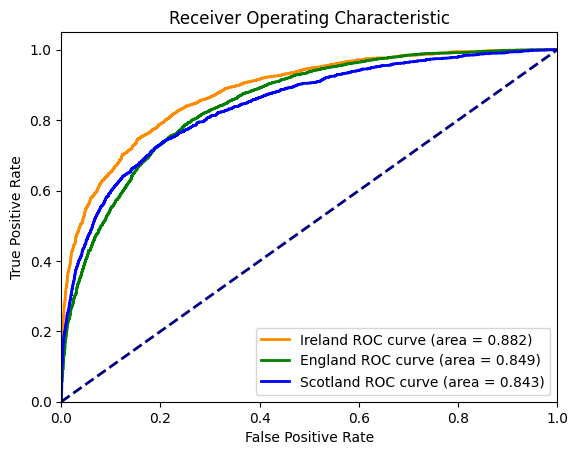

In [22]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = clf.predict_proba(X_valid)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_valid, y_pred_proba[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange', lw=lw, label='Ireland ROC curve (area = %0.3f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1], color='green', lw=lw, label='England ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2], color='blue', lw=lw, label='Scotland ROC curve (area = %0.3f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



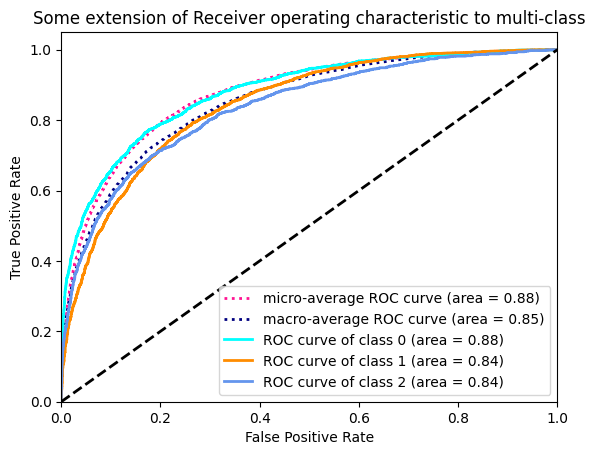

In [35]:
# roc curve for multiclasses
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# shuffle and split training and test sets

X_train, X_test, y_train, y_test = train_test_split(X_stop_lemma, y, test_size=.2, random_state=42)


vectorizer = TfidfVectorizer(strip_accents='unicode', sublinear_tf=True, min_df=3 ,max_features=104000)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(random_state=0, C=2))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.2f})' .format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=lw)
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.2f})' .format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=lw)
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


Average precision score, micro-averaged over all classes: 0.79


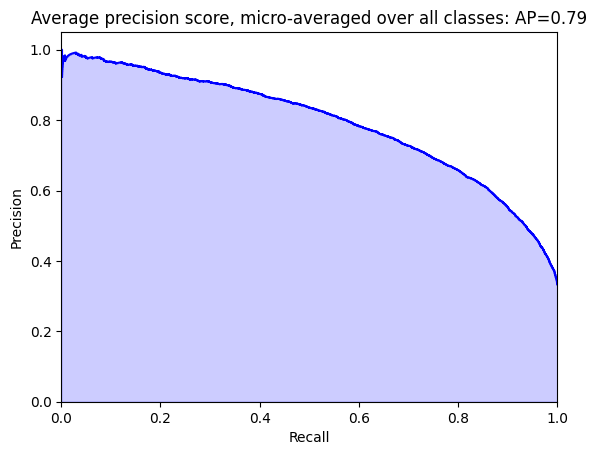

<Figure size 640x480 with 0 Axes>

In [32]:

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score, average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post', color='b')
plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Average precision score, micro-averaged over all classes: AP={0:0.2f}'.format(average_precision["micro"]))
plt.show()


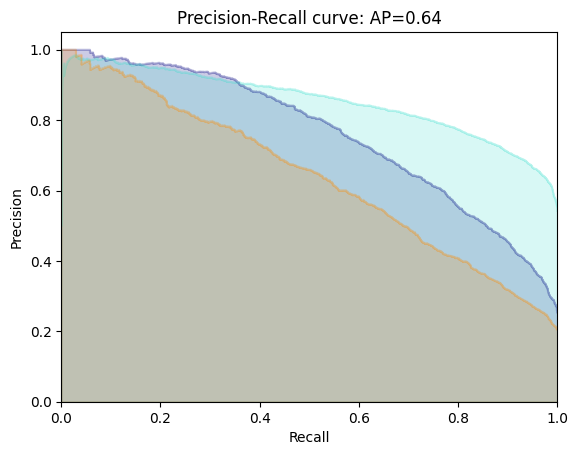

NameError: name 'target_names' is not defined

In [33]:

# Plot Precision-Recall curve for each class and iso-f1 curves
plt.figure()
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
for i, color in zip(range(n_classes), colors):
    plt.step(recall[i], precision[i], color=color, alpha=0.2, where='post')
    plt.fill_between(recall[i], precision[i], step='post', alpha=0.2, color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision[i]))
plt.show()



---


In [ ]:
# tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', sublinear_tf=True, min_df=3 ,max_features=104000)
X_TRAIN = vectorizer.fit_transform(X_stop_lemma)
X_TEST = vectorizer.transform(X_TEST_STOP_LEMMA)

In [ ]:
# logistic regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=2).fit(X_TRAIN, y)

# predict
y_pred = clf.predict(X_TEST)

In [ ]:
id2label = {0: 'Ireland', 1:'England', 2:'Scotland'}

prediction = [id2label[pred] for pred in y_pred]

answer = pd.DataFrame({'id':range(1, len(prediction) + 1),'label': prediction})
answer.to_csv('answer.csv', index=False)